This notebook investigates the signal from the loudest BBH included in the ET MDC 1v2.

In [69]:
from gwpy.timeseries import TimeSeries
from pycbc.waveform import get_td_waveform

import matplotlib.pyplot as plt
import numpy as np
from pycbc.detector import Detector


In [70]:
# Read data containing the loudest BBH
tsd1 = TimeSeries.read('../data/loudest_BBH/loudest_E1.gwf', channel='E1:STRAIN')
tsd2 = TimeSeries.read('../data/loudest_BBH/loudest_E2.gwf', channel='E2:STRAIN')
tsd3 = TimeSeries.read('../data/loudest_BBH/loudest_E3.gwf', channel='E3:STRAIN')

# Bandpass E1 data for better visualization of the signal
tsd = tsd1.bandpass(4, 1024)

In [71]:
# Get parameters of the loudest BBH

params = np.loadtxt('../data/loudest_BBH/list_mdc1_v2.txt')
index_loudest = np.argmax(params[:,-2])
tc_loudest1 = params[index_loudest,2]
tc_loudest2 = params[index_loudest,3]
t0_loudest = params[index_loudest,1]

m1 = params[index_loudest, 4] # Masses are nominally in detector frame
m2 = params[index_loudest, 5]
z = params[index_loudest, 16]
d = params[index_loudest, -8]
s1x = params[index_loudest, 7]
s1y = params[index_loudest, 8]
s1z = params[index_loudest, 9]
s2x = params[index_loudest, 11]
s2y = params[index_loudest, 12]
s2z = params[index_loudest, 13]
iota = params[index_loudest, 21]
phi0 = params[index_loudest, -2]

ra = params[index_loudest,18]
dec = params[index_loudest,19]

E1 = Detector('E1')
E2 = Detector('E2')
E3 = Detector('E3')

dt = E1.time_delay_from_earth_center(ra, dec, tc_loudest1)
print(dt)
print(tc_loudest1)

-0.018522362002287504
1001620460.259507


In [72]:
print(m1, m2)
print(z)
print(m1*(1+z), m2*(1+z))

21.897 21.539
0.1137
24.386688899999996 23.9879843


1001620460.2925069


(1001620460.1595069, 1001620460.359507)

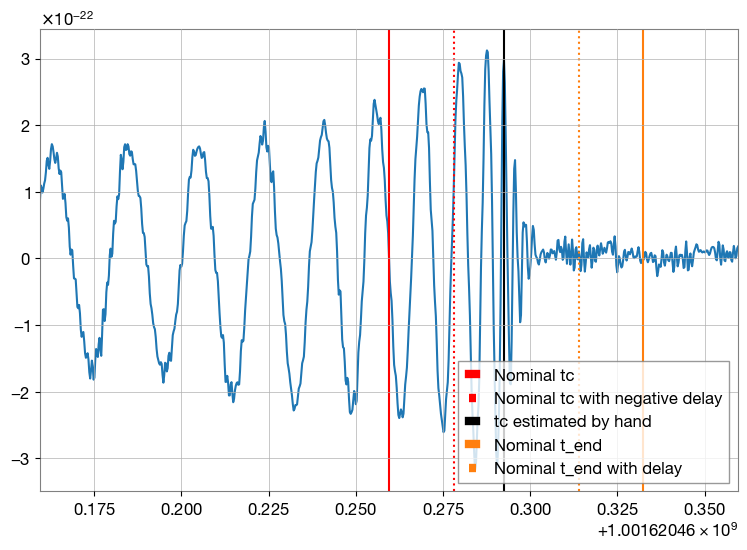

In [73]:
estimated_tc = tc_loudest1 + 0.033
print(estimated_tc)
plt.figure(figsize=(9,6))
ax = plt.gca()
ax.plot(tsd.times, tsd)
ax.axvline(t0_loudest,0, 1, color='green')
ax.axvline(tc_loudest1,0, 1, color='red', label='Nominal tc')
ax.axvline(tc_loudest1 - dt,0, 1, color='red', ls=':', label='Nominal tc with negative delay')

ax.axvline(estimated_tc,0, 1, color='black', label='tc estimated by hand')

ax.axvline(tc_loudest2 ,0, 1, color='C01', label='Nominal t_end')
ax.axvline(tc_loudest2 + dt,0, 1, color='C01', ls=':', label='Nominal t_end with delay')

ax.legend()
ax.set_xlim(tc_loudest1-0.1, tc_loudest1+0.1)

There are two coalescence times reported in the injections list, which differ by ~0.1 s. None of them seem to be completely accurate, even when taking into account the time delay between the center of the earth and the detector. The difference is ~50 ms.

**Hypotheses for why there are 2 coalescence times:**
* Time of arrival at the center of the earth vs at the detector?
* Coalescence time vs end time of the waveform (including merger).

**To do:**
* Check with another signal.

## Generate waveform corresponding to the parameters of the loudest CBC

There are a few complications:
* the MDC list give the phase at origin (when the signal reaches 5 Hz), while pycbc expects the coalescence phase.
* The coalescence time given in the MDC list seems approximative. Besides I didn't find how to specify a coalescence time in get_td_waveform yet.

Therefore I have processed by trial and error to try to match $t_c$ and $\phi_c$ as well as possible.

In [79]:
approximant = 'IMRPhenomXPHM'
hp, hc = get_td_waveform(mass1=m1*(1+z), mass2=m2*(1+z), distance=d, approximant=approximant, f_lower=5, delta_t=1/4096, tc=tc_loudest1, spin1x=s1x,\
                        spin1y=s1y, spin1z=s1z, spin2x=s2x, spin2y=s2y, spin2z=s2z, inclination=iota, coa_phase=np.pi/2-0.4, polarization=params[index_loudest, 20])

offset = tc_loudest1 - hp.get_end_time() + 5.0322 # Offset is selected by hand
hp.start_time = hp.start_time + offset
hc.start_time = hc.start_time + offset

(-1e-22, 1e-22)

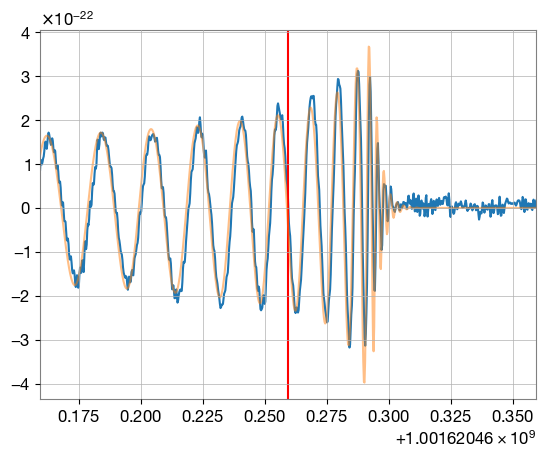

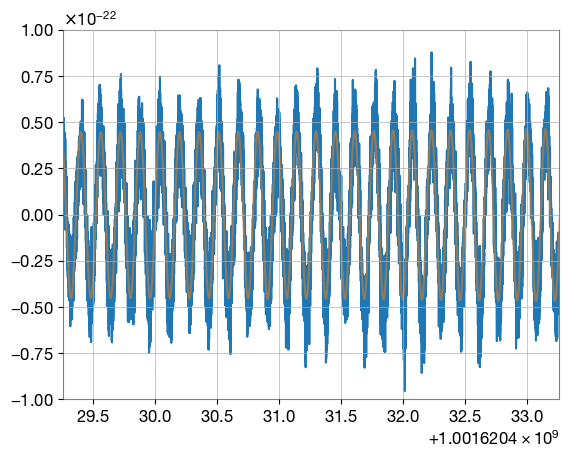

In [80]:
fp, fx = E1.antenna_pattern(params[index_loudest,18], params[index_loudest,19], params[index_loudest,20], tc_loudest1)
h = fp * hp + fx * hc # Does not take time delay into account because it is degenerated with tc.
plt.figure()
ax = plt.gca()
ax.plot(tsd.times, tsd)
ax.axvline(t0_loudest,0, 1, color='green')
ax.axvline(tc_loudest1,0, 1, color='red')
ax.plot(h.get_sample_times() , h, alpha=0.5)
#ax.set_xlim(tc_loudest -0.1, tc_loudest-0)
ax.set_xlim(tc_loudest1 -0.1, tc_loudest1+0.1)

plt.figure()
ax = plt.gca()
ax.plot(tsd.times, tsd)
ax.axvline(t0_loudest,0, 1, color='green')
ax.axvline(tc_loudest1,0, 1, color='red')
ax.plot(h.get_sample_times() , h, alpha=0.5)
ax.set_xlim(tc_loudest1 -31, tc_loudest1-27)
ax.set_ylim(-1e-22, 1e-22)

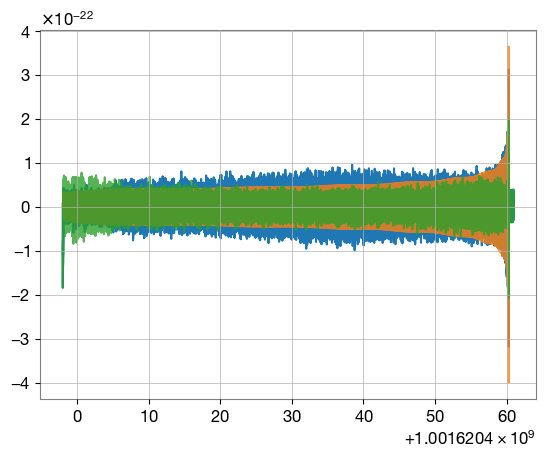

In [76]:
t1 = tsd.times.value
t2 = h.get_sample_times().data

h1 = tsd.value
h2 = h.data

from scipy.interpolate import interp1d

h_of_t = interp1d(t2, h2, bounds_error=False, fill_value=0)
h_new = h_of_t(t1)

plt.figure()
ax = plt.gca()
ax.plot(t1, h1)
ax.plot(t1, h_new, alpha=0.8)
ax.plot(t1, h1 - h_new, alpha=0.8)

#ax.set_xlim(tc_loudest -11, tc_loudest-10)


(1001620402.332455, 1001620403.332455)

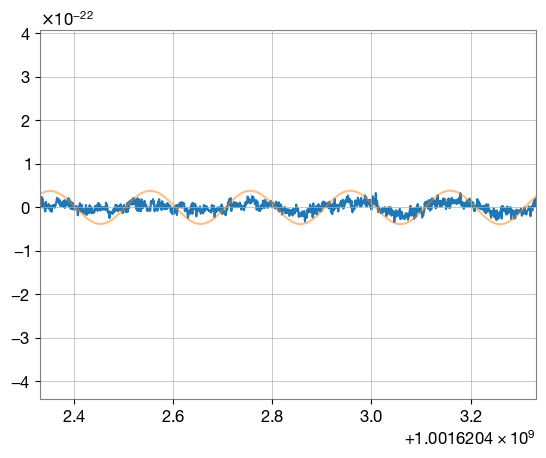

In [414]:
plt.figure()
ax = plt.gca()
ax.plot(tsd.times, tsd)
ax.axvline(t0_loudest,0, 1, color='green')
ax.axvline(tc_loudest,0, 1, color='red')
ax.plot(h.get_sample_times() , h, alpha=0.5)
ax.set_xlim(tc_loudest -58, tc_loudest-57)


### Issue 1: masses

The MDC list gives the two masses $m_1$ and $m_2$ and the redshift $z$ of the loudest signal. The signals match best when we generate a CBC signal with pyCBC with masses $m_1 (1+z)$ and $m_2(1+z)$. This suggests that the MDC masses are given in the source frame, and pyCBC expects masses in the detector frame.

However it is said in the MDC documentation that masses are given in the detector frame. This is confirmed by the fact that we were able to recover the chirp mass of BNS with PySTAMPAS from the time-frequency representation, and the recovery was compatible with the listed $m_1$ and $m_2$ (without the $(1+z)$ factor).

**Solution:** it appears that masses in the NEW list are now in the source frame instead of the detector frame.

In [398]:
hp1, hc1 = get_td_waveform(mass1=m1, mass2=m2, distance=500, approximant=approximant, f_lower=5, delta_t=1/4096, tc=tc_loudest, spin1x=s1x,\
                        spin1y=s1y, spin1z=s1z, spin2x=s2x, spin2y=s2y, spin2z=s2z, inclination=iota, coa_phase=np.pi/2-0.4)

hp2, hc2 = get_td_waveform(mass1=m1, mass2=m2, distance=5, approximant=approximant, f_lower=5, delta_t=1/4096, tc=tc_loudest, spin1x=s1x,\
                        spin1y=s1y, spin1z=s1z, spin2x=s2x, spin2y=s2y, spin2z=s2z, inclination=iota, coa_phase=np.pi/2-0.4)



(-60.0, 2.0)

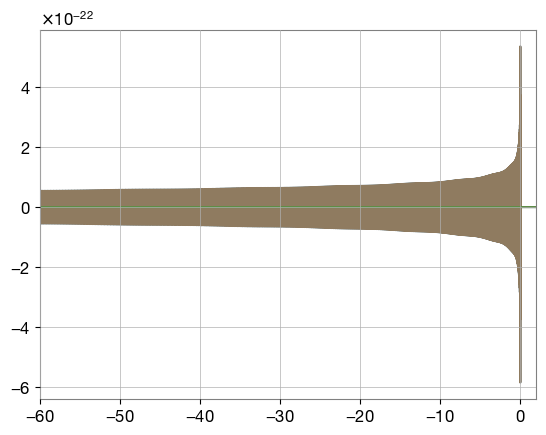

In [388]:
plt.plot(hp1.get_sample_times(), hp1)
plt.plot(hp2.get_sample_times(), hp2/100, alpha=0.5)
plt.plot(hp2.get_sample_times(), hp1-hp2/100, alpha=0.5)

plt.xlim(-60,2)